In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
try:
    import Image
except ImportError:
    from PIL import Image

import PIL
import os 
import pytesseract

In [3]:
imgs_path = "./imgs"

imgs_names = [path for path in os.listdir(imgs_path) if path.endswith('.bmp')]

In [4]:
imgs = [cv2.imread(os.path.join(imgs_path, name), cv2.IMREAD_GRAYSCALE) for name in imgs_names]

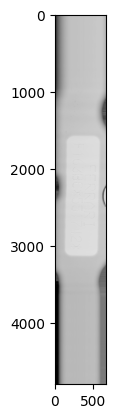

In [5]:
plt.imshow(imgs[0], cmap='gray')
plt.show()

# Sobel

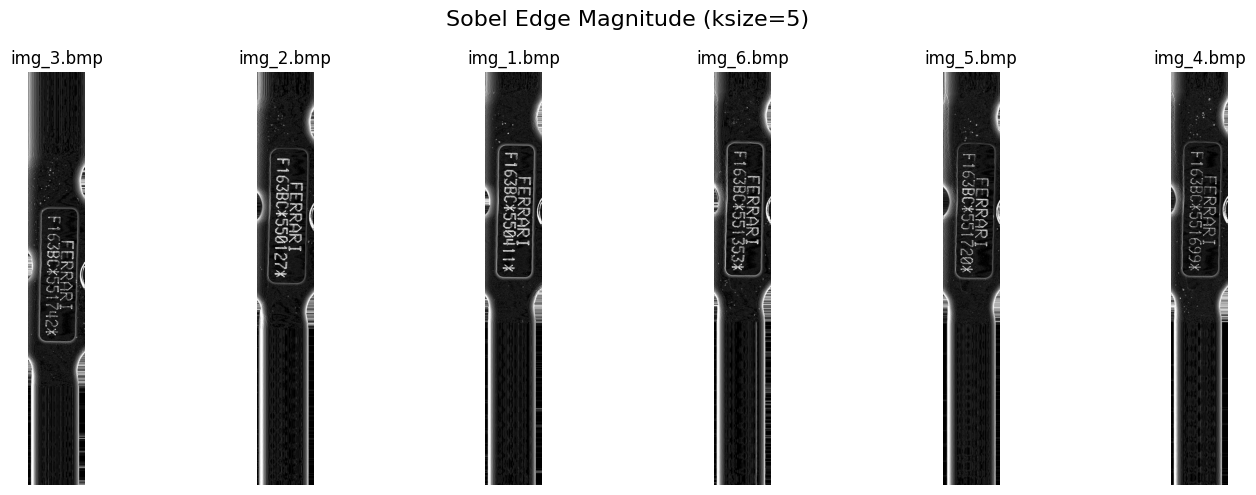

In [6]:
sobel_magnitudes = []
for img in imgs:
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = cv2.magnitude(sobelx, sobely)
    magnitude = cv2.convertScaleAbs(magnitude)
    sobel_magnitudes.append(magnitude)

fig, axes = plt.subplots(1, len(sobel_magnitudes), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(sobel_magnitudes[i], cmap='gray')
    ax.set_title(imgs_names[i])
    ax.axis('off')
plt.suptitle("Sobel Edge Magnitude (ksize=5)", fontsize=16)
plt.tight_layout()
plt.show()

# Laplacian

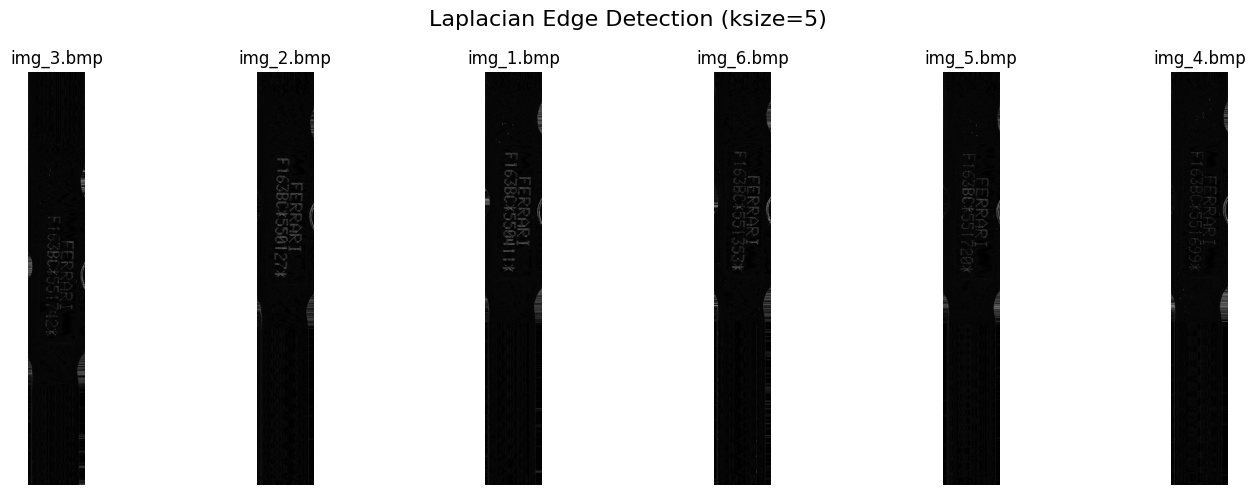

In [6]:
laplacian_imgs = [cv2.Laplacian(img, cv2.CV_8U, ksize=5) for img in imgs]
fig, axes = plt.subplots(1, len(laplacian_imgs), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(laplacian_imgs[i], cmap='gray')
    ax.set_title(imgs_names[i])
    ax.axis('off')
plt.suptitle("Laplacian Edge Detection (ksize=5)", fontsize=16)
plt.tight_layout()
plt.show()

# Prewitt

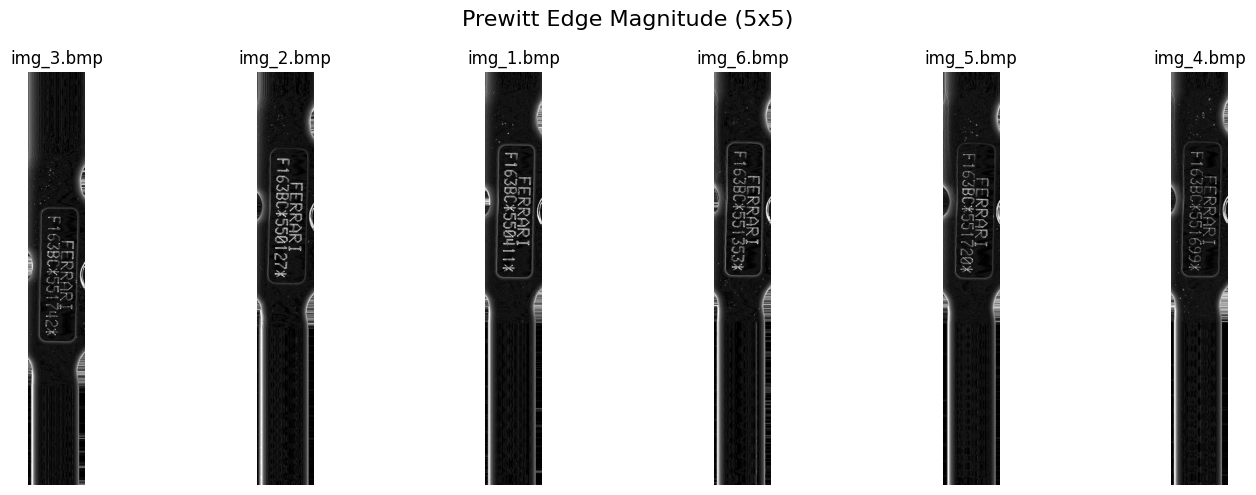

In [7]:
# Define 5x5 Prewitt kernels
kernelx_5x5 = np.array([
    [1, 1, 1, 1, 1],
    [1, 10, 10, 10, 1],
    [0, 0, 0, 0, 0],
    [-1, -10, -10, -10, -1],
    [-1, -1, -1, -1, -1]
])

kernely_5x5 = np.array([
    [-1, -1, 0, 1, 1],
    [-1, -10, 0, 10, 1],
    [-1, -10, 0, 10, 1],
    [-1, -10, 0, 10, 1],
    [-1, -1, 0, 1, 1]
])

# Apply 5x5 Prewitt operator to all images
prewitt_5x5_magnitudes = []

for img in imgs:
    # Apply Prewitt operators
    prewitt_x = cv2.filter2D(img, cv2.CV_64F, kernelx_5x5)
    prewitt_y = cv2.filter2D(img, cv2.CV_64F, kernely_5x5)
    
    # Calculate magnitude
    magnitude = cv2.magnitude(prewitt_x, prewitt_y)
    magnitude = cv2.convertScaleAbs(magnitude)
    prewitt_5x5_magnitudes.append(magnitude)

# Plot results
fig, axes = plt.subplots(1, len(prewitt_5x5_magnitudes), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(prewitt_5x5_magnitudes[i], cmap='gray')
    ax.set_title(f'{imgs_names[i]}')
    ax.axis('off')
plt.suptitle("Prewitt Edge Magnitude (5x5)", fontsize=16)
plt.tight_layout()
plt.show()

# Roberts

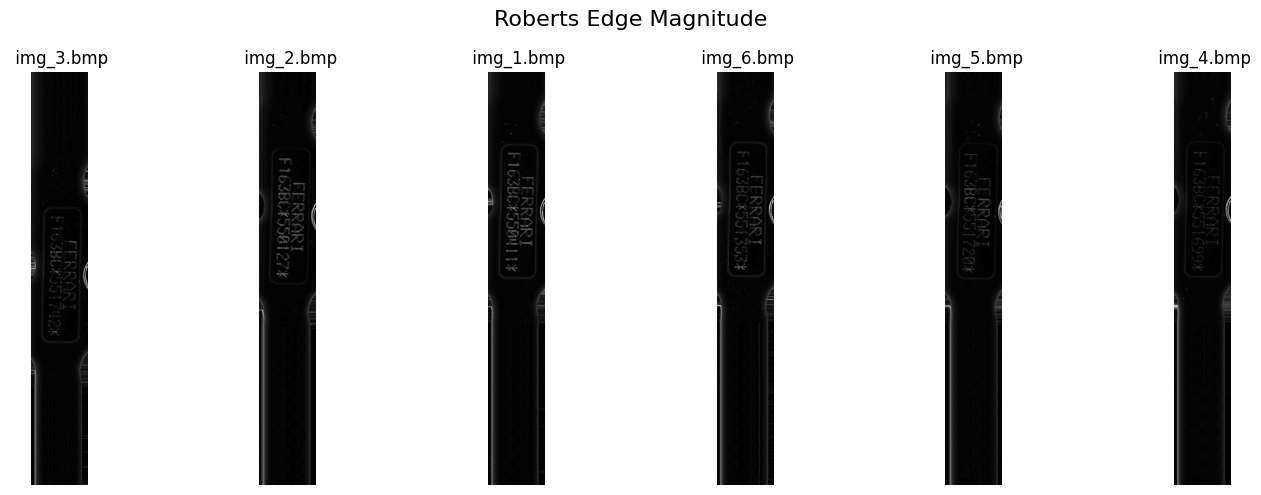

In [8]:
# Define 5x5 Roberts Cross kernels
roberts_cross_1 = np.array([
    [1, 1, 1, 1, 0],
    [1, 1, 1, 0, -1],
    [1, 1, 0, -1, -1],
    [1, 0, -1, -1, -1],
    [0, -1, -1, -1, -1],
], dtype=np.float32)

roberts_cross_2 = np.array([
    [0, 1, 1, 1, 1],
    [-1, 0, 1, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, -1, 0, 1],
    [-1, -1, -1, -1, 0]
], dtype=np.float32)

# Apply 5x5 Roberts operator to all images
roberts_5x5_magnitudes = []

for img in imgs:
    # Apply Roberts operators
    roberts_x = cv2.filter2D(img, cv2.CV_64F, roberts_cross_1)
    roberts_y = cv2.filter2D(img, cv2.CV_64F, roberts_cross_2)
    
    # Calculate magnitude
    magnitude = cv2.magnitude(roberts_x, roberts_y)
    magnitude = cv2.convertScaleAbs(magnitude)
    roberts_5x5_magnitudes.append(magnitude)

# Plot results
fig, axes = plt.subplots(1, len(roberts_5x5_magnitudes), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(roberts_5x5_magnitudes[i], cmap='gray')
    ax.set_title(f' {imgs_names[i]}')
    ax.axis('off')
plt.suptitle("Roberts Edge Magnitude", fontsize=16)
plt.tight_layout()
plt.show()

# Canny

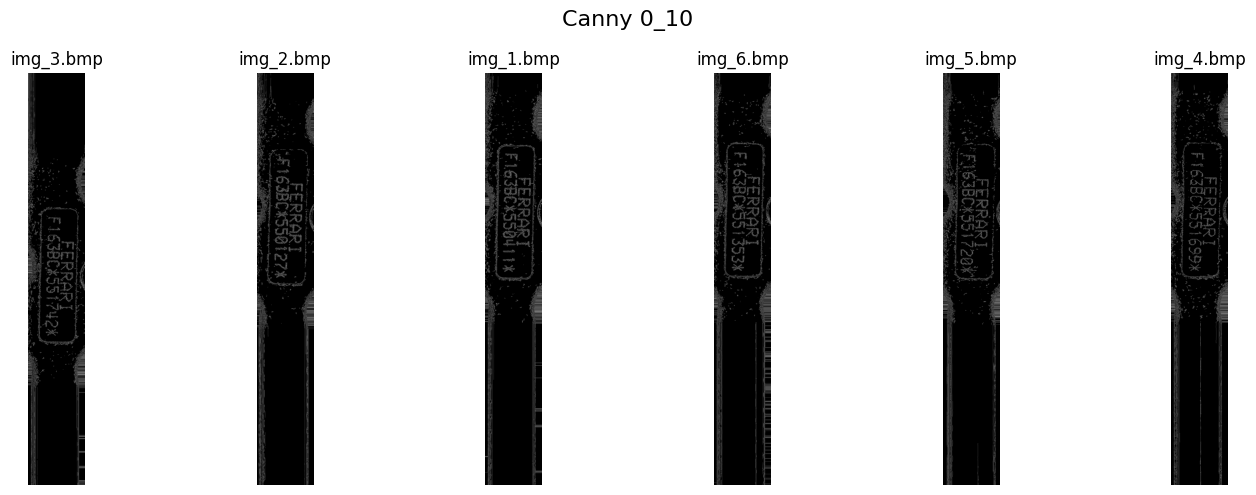

In [9]:
# Apply Canny edge detection to all images
canny_imgs = []

# Use different threshold values for better edge detection
low_threshold = 0
high_threshold = 10

for img in imgs:
    # Apply Canny edge detection
    canny = cv2.Canny(img, low_threshold, high_threshold)
    canny_imgs.append(canny)

# Plot results
fig, axes = plt.subplots(1, len(canny_imgs), figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(canny_imgs[i], cmap='gray')
    ax.set_title(f'{imgs_names[i]}')
    ax.axis('off')
plt.suptitle("Canny 0_10", fontsize=16)
plt.tight_layout()
plt.show()

# Recognition

# some huggingface model 

In [6]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests


/home/malio/softsys/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
image = sobel_magnitudes[0]

In [8]:
# Convert grayscale image to RGB format
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

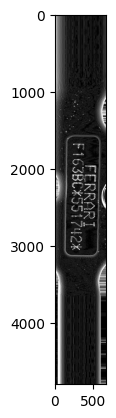

In [9]:
plt.imshow(image)
plt.show()

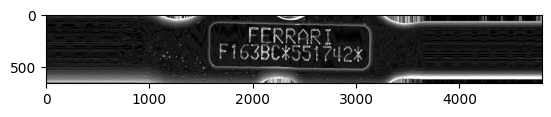

In [10]:

# Rotate the image by 90 degrees clockwise
image_rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(image_rotated)
plt.show()

In [13]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')
pixel_values = processor(images=image_rotated, return_tensors="pt").pixel_values


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [15]:
generated_text

['(REGIPT)']

# Tesseract

In [7]:
import pytesseract

In [8]:
image = sobel_magnitudes[0]
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

In [9]:
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print(f"Image min value: {image.min()}")
print(f"Image max value: {image.max()}")
print(f"Number of channels: {image.shape[2] if len(image.shape) == 3 else 1}")

Image shape: (4800, 660, 3)
Image dtype: uint8
Image min value: 0
Image max value: 255
Number of channels: 3


In [10]:
# Check if image is in BGR or RGB format
if len(image.shape) == 3:
    print(f"Image has {image.shape[2]} channels")
    print(f"Red channel range: {image[:,:,0].min()} - {image[:,:,0].max()}")
    print(f"Green channel range: {image[:,:,1].min()} - {image[:,:,1].max()}")
    print(f"Blue channel range: {image[:,:,2].min()} - {image[:,:,2].max()}")
else:
    print("Image is grayscale")

Image has 3 channels
Red channel range: 0 - 255
Green channel range: 0 - 255
Blue channel range: 0 - 255


In [15]:
pil_image = Image.open("/home/malio/softsys/Screenshot 2025-07-28 143906.png")
pil_image.format

'PNG'

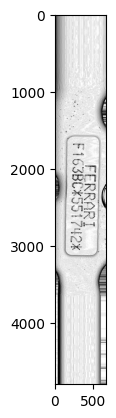

In [22]:
plt.imshow(image)
plt.show()

In [21]:
image = 255 - image

In [24]:
# Configure Tesseract for grayscale image and English language
custom_config = r'--oem 3 --psm 6 -l eng'
print(pytesseract.image_to_string(image, config=custom_config))

MI |
hI i
i
| | !)/})
i} | |
my) | |
\
||
| iM |
HH |
|
| iil | |
| Hh ||
nH)
HI
|| |
| |
| | | |
1 |
men |) |) i |
1} j |
| | | |
WO | | |
Hy) |
| HI | |
Ml | |
IN) Hh | Kilt
| iN | |
mY WK |) i
DAN) {t
ey) a if
Rays e i
By 4) ay ihe
Be 4) 5 3 s ue
we a aie ye
Be Y
y ener, a @ iB
Be ; Sr: oO
a > ‘ Bh
iS t ° a). =
may e i
Bisa °° eo” ay
eh 7 me * * =
Bet, 2 ae
hy § 9 oS
by oe Y ae
i oo 9 :
i Fae nm :
12). eee een a ae
He } ff y
iy f
eS! i 1
Hite ” it
Pe i i iB ;
Bi Ae) i u f
i am 4 i
Ye fi ° i)
at a Cal | f
NS \ é(
SS Xe Ms (
% Bb Cr rr b
= ? i & :
Bs) 8
A Ht; > -.' 2
ey) 4a u P \
7 , q f fs ,
eg 3 f ‘ h
ee ‘ f F i ;
Wa i, : ;
i Om i » b. «
ii G ry f : Bice
His i is ery r x
2 , oe
hy | er I f
i weet J } eee
ee
>) Nie |.
Bes a
fir. ij oe. b °
i lt 3 k
q
; is ¢
\ \ y
wa
a x % : 2 j ig
Ns: \ Es : i
=) 4
Bi ie
ie aa
‘ {ia
b q
ig : \ :
' (My
i a
| | —
|
/ |
| |,
|
| |
|
|
|
|
| {|
| |
| |
! |
|
|
! |
:
| |
! |
| {
}
|
i |
|
|
| L_
Wi i



In [8]:
image = cv2.imread("/home/malio/softsys/Screenshot 2025-07-28 143906.png", cv2.IMREAD_COLOR_BGR)


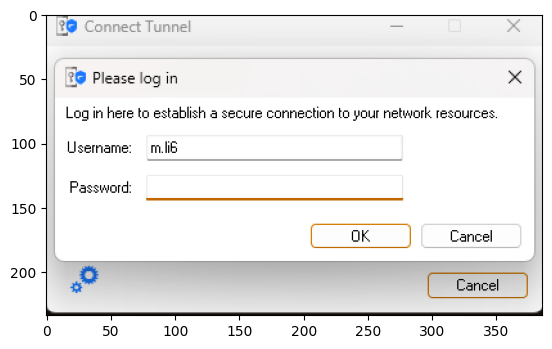

In [9]:
plt.imshow(image)
plt.show()

In [10]:
print(pytesseract.image_to_string(image))

 

  

Please log in x

Log in here ta establish a secure connection to your network resaurces.

Usemame: mi

 

 



# Pix2text

In [18]:
import os
from pix2text import Pix2Text

p2t = Pix2Text.from_config()

[WARNING 2025-07-31 15:19:16,956 _assert_and_prepare_model_files:177] no onnx file is found in /home/malio/.cnocr/2.3/densenet_lite_136-gru 
[WARNING 2025-07-31 15:19:17,575 _assert_and_prepare_model_files:183] can not find model file /home/malio/.cnstd/1.2/ppocr/ch_PP-OCRv5_det/ch_PP-OCRv5_det_infer.onnx 
/home/malio/softsys/.venv/lib/python3.12/site-packages/huggingface_hub/commands/download.py:141: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/home/malio/softsys/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Download complete. Moving file to /home/malio/.cnstd/1.2/ppocr/ch_PP-OCRv5_det/README.md
Download complete. Moving file to /home/malio/.cnstd/1.2/ppocr/ch_PP-OCRv5_det/config.yaml
Download complete. Moving file to /home/malio/.cnstd/1.2/ppocr/ch_PP-OCRv5_det/ch_PP-OCRv5_det_infer.onnx
Download complete. Moving file to /home/malio/.cnstd/1.2/ppocr/ch_PP-OCRv5_det/.gitattributes
Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00,  8.30it/s]
[INFO] 2025-07-31 15:19:18,439 [RapidOCR] base.py:24: Using engine_name: onnxruntime
[INFO] 2025-07-31 15:19:18,444 [RapidOCR] main.py:55: Using /home/malio/.cnstd/1.2/ppocr/ch_PP-OCRv5_det/ch_PP-OCRv5_det_infer.onnx
[WARNING] 2025-07-31 15:19:18,445 [RapidOCR] provider_config.py:95: CUDAExecutionProvider is not in available providers (['AzureExecutionProvider', 'CPUExecutionProvider']). Use AzureExecutionProvider inference by default.
[INFO] 2025-07-31 15:19:18,446 [RapidOCR] provider_config.py:170: If you want to use CUDAExecutionProvider accelerat

/home/malio/.cnstd/1.2/ppocr/ch_PP-OCRv5_det


/home/malio/softsys/.venv/lib/python3.12/site-packages/huggingface_hub/commands/download.py:141: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/home/malio/softsys/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Download complete. Moving file to /home/malio/.pix2text/1.1/mfd-1.5-onnx/.gitattributes
Fetching 4 files:  25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]Downloading 'README.md' to '/home/malio/.pix2text/1.1/mfd-1.5-onnx/.cache/huggingface/download/Xn7B-BWUGOee2Y6hCZtEhtFu4BE=.f8e531eb2e50ce4677da59e4605ca598f917470f.incomplete'
Download complete. Moving file to /home/malio/.pix2text/1.1/mfd-1.5-onnx/config.yaml
Download complete. Moving file to /home/malio/.pix2text/1.1/mfd-1.5-onnx/README.md
Download complete. Moving file to /home/malio/.pix2text/1.1/mfd-1.5-onnx/pix2text-mfd-1.5.onnx
Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


/home/malio/.pix2text/1.1/mfd-1.5-onnx


/home/malio/softsys/.venv/lib/python3.12/site-packages/huggingface_hub/commands/download.py:141: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/home/malio/softsys/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Download complete. Moving file to /home/malio/.pix2text/1.1/mfr-1.5-onnx/special_tokens_map.json
Download complete. Moving file to /home/malio/.pix2text/1.1/mfr-1.5-onnx/preprocessor_config.json
Download complete. Moving file to /home/malio/.pix2text/1.1/mfr-1.5-onnx/.gitattributes
Fetching 10 files:  10%|█         | 1/10 [00:00<00:01,  5.76it/s]Downloading 'generation_config.json' to '/home/malio/.pix2text/1.1/mfr-1.5-onnx/.cache/huggingface/download/3EVKVggOldJcKSsGjSdoUCN1AyQ=.e0ced48cc2d1373fd18b3a7d2f06a45e204226a0.incomplete'
Download complete. Moving file to /home/malio/.pix2text/1.1/mfr-1.5-onnx/generation_config.json
Download complete. Moving file to /home/malio/.pix2text/1.1/mfr-1.5-onnx/README.md
Download complete. Moving file to /home/malio/.pix2text/1.1/mfr-1.5-onnx/tokenizer.json
Download complete. Moving file to /home/malio/.pix2text/1.1/mfr-1.5-onnx/tokenizer_config.json
Download complete. Moving file to /home/malio/.pix2text/1.1/mfr-1.5-onnx/config.json
Fetching 10 fil

/home/malio/.pix2text/1.1/mfr-1.5-onnx


[WARNING 2025-07-31 15:19:22,639 _showwarnmsg:112] /home/malio/softsys/.venv/lib/python3.12/site-packages/pix2text/latex_ocr.py:360: SyntaxWarning: invalid escape sequence '\l'
  """匹配左右括号，如匹配 `\left(` 和 `\right)`。"""
 
[WARNING 2025-07-31 15:19:22,640 _showwarnmsg:112] /home/malio/softsys/.venv/lib/python3.12/site-packages/pix2text/latex_ocr.py:371: SyntaxWarning: invalid escape sequence '\{'
  ('\{', '.'),  # 大括号那种
 


ValueError: Asked to use CUDAExecutionProvider as an ONNX Runtime execution provider, but the available execution providers are ['AzureExecutionProvider', 'CPUExecutionProvider'].